# Solve utility-scale quantum optimization problems

<em>Estimated QPU usage: 8 minutes (tested on IBM Sherbrooke)</em>


This tutorial demonstrates how to implement the **Quantum Approximate Optimization Algorithm (QAOA)** -- a hybrid (quantum-classical) iterative method -- within the context of Qiskit patterns. You will first solve the **Maximum-Cut** (or **Max-Cut**) problem for a small graph and then learn how to execute it at utility scale. All the hardware executions in the notebook should run within the time limit for the freely-accessible Open Plan.


The Max-Cut problem is an optimization problem that is hard to solve (more specifically, it is an *NP-hard* problem) with a number of different applications in clustering, network science, and statistical physics. This tutorial considers a graph of nodes connected by vertices, and aims to partition it into separate graphs such that they are both as large as possible. Put another way, the goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized.

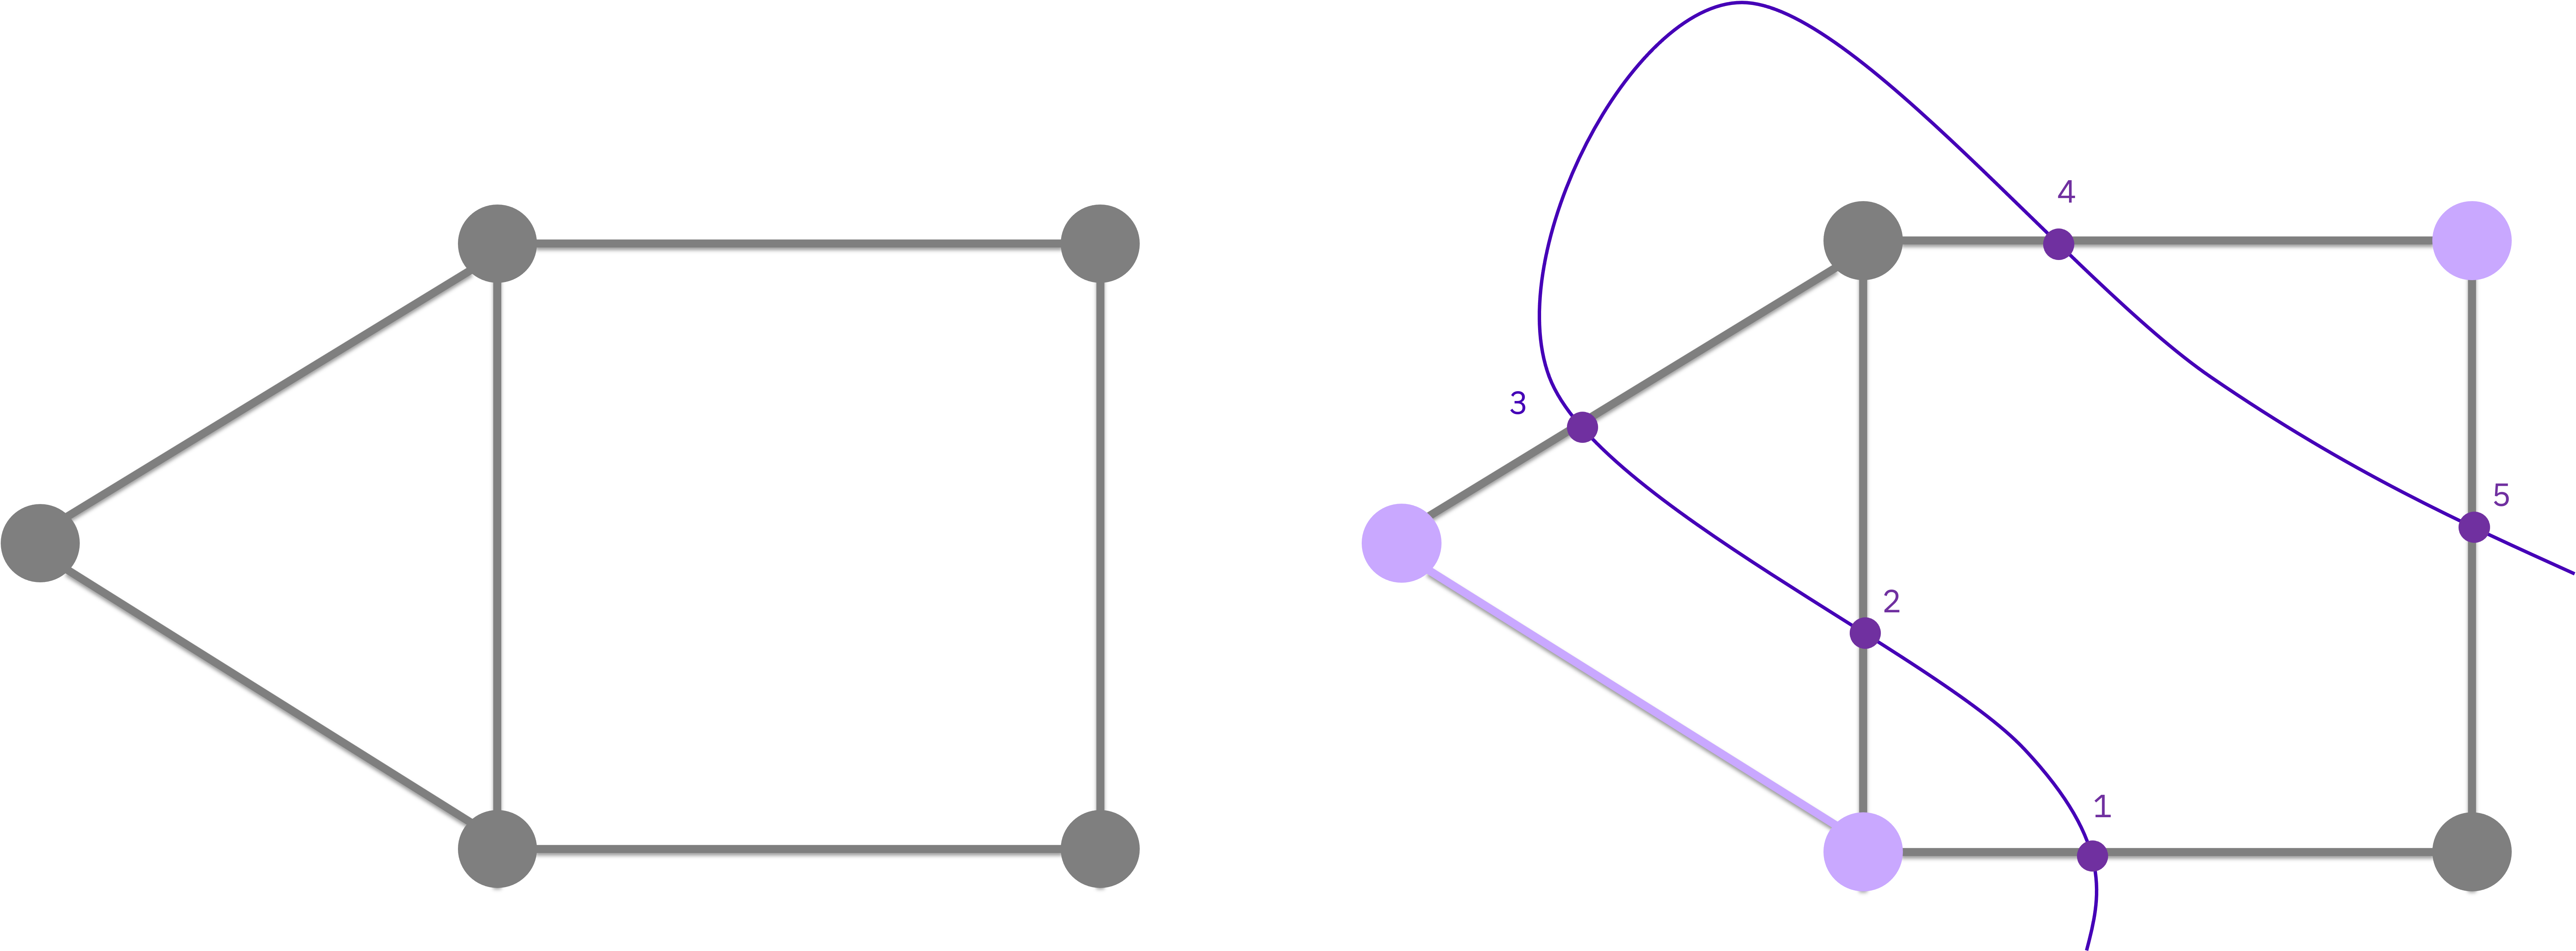

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
- Rustworkx graph library (`pip install rustworkx`)

# Part 1: Small-scale QAOA
The first part of this tutorial uses a small-scale Max-Cut problem to illustrate the steps to solve an optimization problem using a quantum computer.

To give some context before mapping this problem to a quantum algorithm, you can better understand how the Max-Cut problem becomes a classical combinatorial optimization problem by first considering the minimization of a function $f(x)$

\begin{align}
\min_{x\in \{0, 1\}^n}f(x),
\end{align}

where the input $x$ is a vector whose components correspond to each node of a graph.  Then, constrain each of these components to be either $0$ or $1$ (which represent being included or not included in the cut). This small-scale example case uses a graph with $n=5$ nodes.

You could write a function of a pair of nodes $i,j$ which indicates whether the corresponding edge $(i,j)$ is in the cut. For example, the function $x_i + x_j - 2 x_i x_j$ is 1 only if one of either $x_i$ or $x_j$ are 1 (which means that the edge is in the cut) and zero otherwise. The problem of maximizing the edges in the cut can be formulated as

\begin{align}
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
\end{align}

which can be rewritten as a minimization of the form

\begin{align}
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
\end{align}

The minimum of $f(x)$ in this case is when the number of edges traversed by the cut is maximal. As you can see, there is nothing relating to quantum computing yet. You need to reformulate this problem into something that a quantum computer can understand.


Initialize your problem by creating a graph with $n=5$ nodes.

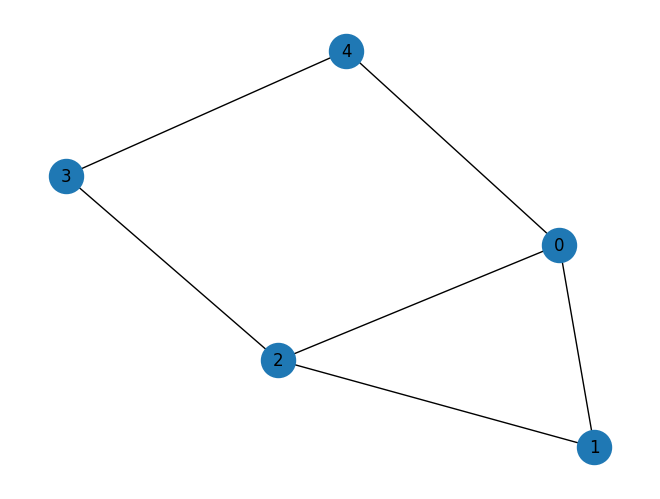

In [4]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

## Step 1. Map classical inputs to a quantum problem

The first step of the pattern is to map the classical problem (graph) into quantum **circuits** and **operators**. To do this, there are three main steps to take:

1. Utilize a series of mathematical reformulations, to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.
2. Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function.
3. Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.


<div class="alert alert-block alert-info">
In the QAOA methodology, you ultimately want to have an operator (<b>Hamiltonian</b>) that represents the <b>cost function</b> of our hybrid algorithm, as well as a parametrized circuit (<b>Ansatz</b>) that represents quantum states with candidate solutions to the problem. You can sample from these candidate states and then evaluate them using the cost function.
</div>


### Graph &rarr; optimization problem

The first step of the mapping is a notation change, The following expresses the problem in QUBO notation:

\begin{align}
\min_{x\in \{0, 1\}^n}x^T Q x,
\end{align}

where $Q$ is a $n\times n$ matrix of real numbers, $n$ corresponds to number of nodes in your graph, $x$ is the vector of binary variables introduced above, and $x^T$ indicates the transpose of the vector $x$.

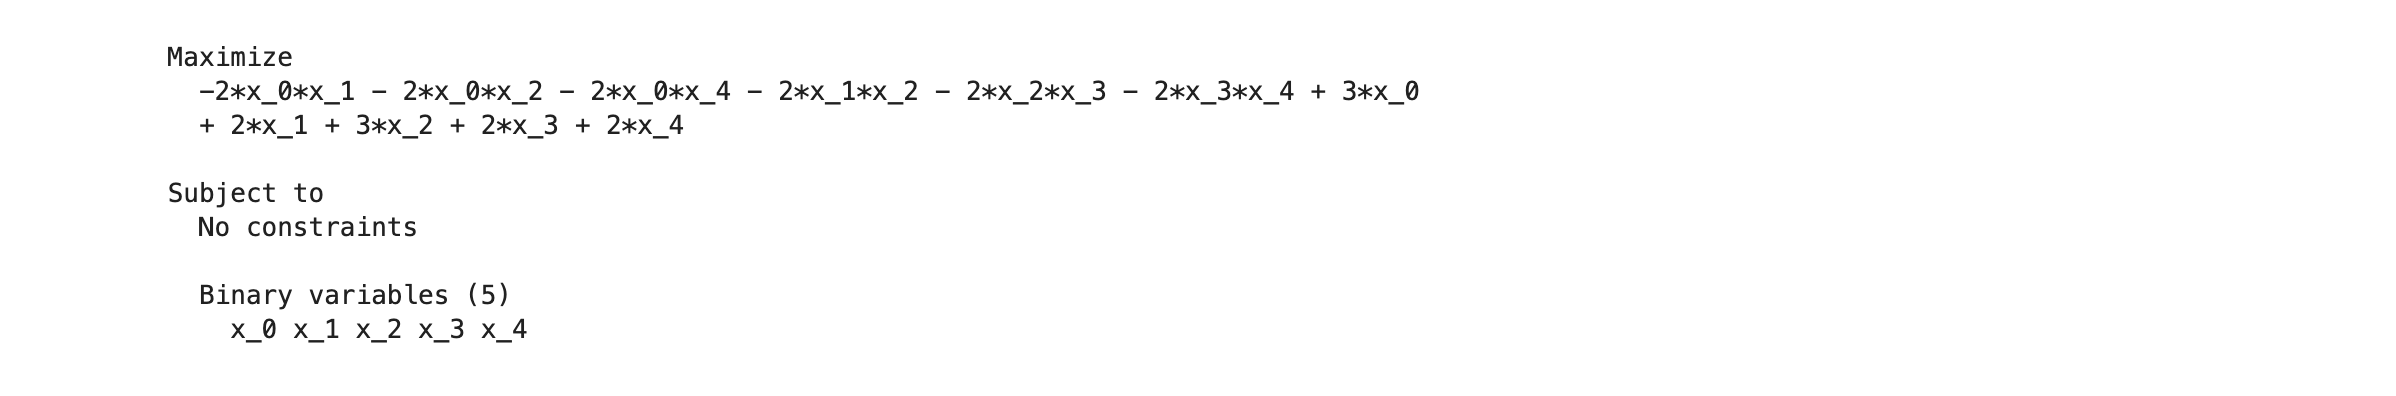

### Optimization problem &rarr; Hamiltonian

You can then reformulate the QUBO problem as a **Hamiltonian** (here, a matrix that represents the energy of a system):

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

<details>
  <summary>
    Reformulation steps from the QAOA problem to the Hamiltonian
  </summary>
To demonstrate how the QAOA problem can be rewritten in this way, first replace the binary variables $x_i$ to a new set of variables $z_i\in\{-1, 1\}$ via

\begin{align}
x_i = \frac{1-z_i}{2}.
\end{align}

Here you can see that if $x_i$ is $0$, then $z_i$ must be $1$. When the $x_i$'s are substituted for the $z_i$'s in the optimization problem ($x^TQx$), an equivalent formulation can be obtained 
\begin{align}
x^TQx&=\sum_{ij}Q_{ij}x_ix_j \\ &=\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\&=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
\end{align}

Now if we define $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$, remove the prefactor, and the constant $n^2$ term, we arrive at the two equivalent formulations of the same optimization problem
\begin{align}
\min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped the factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization. 


Now, to obtain a quantum formulation of the problem, promote the $z_i$ variables to a Pauli $Z$ matrix, such as a $2\times 2$ matrix of the form

\begin{align}
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
\end{align}

When you substitute these matrices in the optimization problem above, you obtain the following Hamiltonian

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

*Also recall that the $Z$ matrices are embedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ embedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.*
</details>


This Hamiltonian is called the <b>cost function Hamiltonian</b>. It has the property that its ground state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve your optimization problem you now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min~f(x)$.




In [5]:
from qiskit.quantum_info import SparsePauliOp


def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### Hamiltonian &rarr; quantum circuit

The Hamiltonian $H_c$ contains the quantum definition of your problem. Now you can create a quantum circuit that will help *sample* good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.

The general idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that you are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$.  

    
The quantum circuit that you generate is **parametrized** by $\gamma_i$ and $\beta_i$, so you can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.

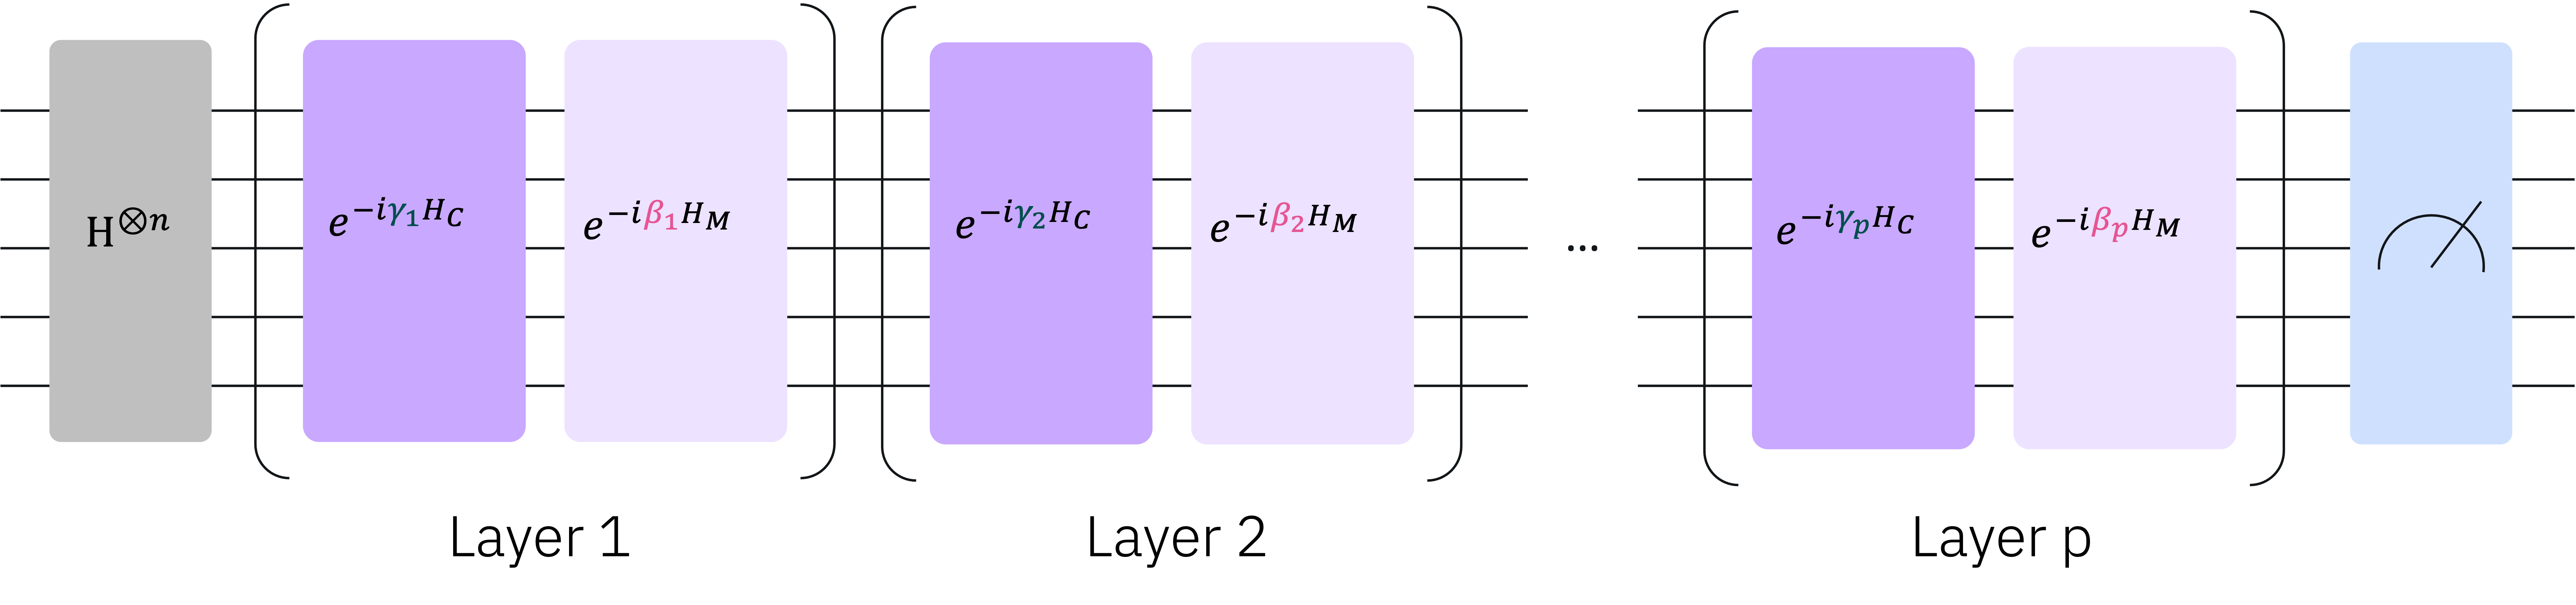


In this case, you will try an example with one QAOA layer that contains two parameters: $\gamma_1$ and $\beta_1$.



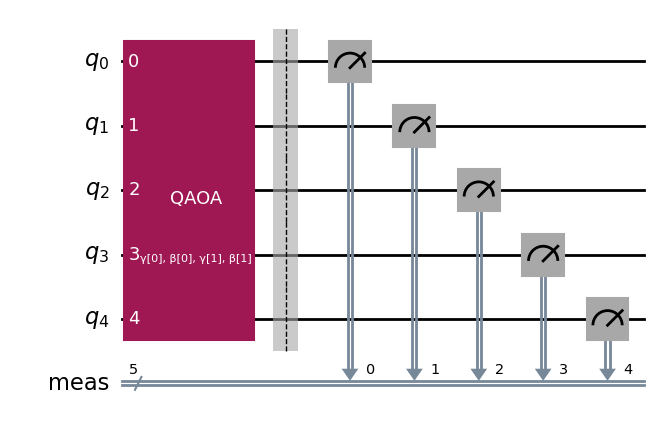

In [6]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw("mpl")

In [7]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

## Step 2. Optimize circuits for quantum hardware execution

The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run on the hardware. To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. You need to make sure that your circuit is **optimized** for your purpose. 

Transpilation may involves several steps, such as:

<div class="alert alert-block alert-info">
    <ul>
      <li><b>Initial mapping</b> of the qubits in the circuit (such as decision variables) to physical qubits on the device.</li>
      <li><b>Unrolling</b> of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.</li>
      <li><b>Routing</b> of any qubits in the circuit that interact to physical qubits that are adjacent with one another.</li>
      <li><b>Error suppression</b> by adding single-qubit gates to suppress noise with dynamical decoupling.
    </ul> 

</div>

More information about transpilation is available in our [documentation](https://docs.quantum.ibm.com/transpile).

The following code transforms and optimizes the abstract circuit into a format that is ready for execution on one of devices accessible through the cloud using the **Qiskit IBM Runtime service**.


<IBMBackend('ibm_sherbrooke')>


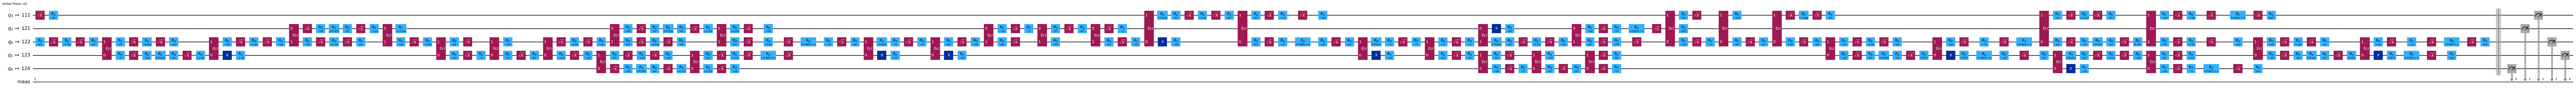

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

## Step 3. Execute using Qiskit primitives

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. This execution loop is executed via the following steps:

1. Define the initial parameters
2. Instantiate a new `Session` containing the optimization loop and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.



### Define circuit with initial parameters
We start with arbitrary chosen parameters.

In [11]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

### Define backend and execution primitive
Use the **Qiskit Runtime primitives** to interact with IBM&reg; backends. The two primitives are Sampler and Estimator, and the choice of primitive depends on what type of measurement you want to run on the quantum computer. For the minimization of $H_c$, use the Estimator since the measurement of the cost function is simply the expectation value of $\langle H_c \rangle$. 

### Run

The primitives offer a variety of [execution modes](https://docs.quantum.ibm.com/run/execution-modes) to schedule workloads on quantum devices, and a QAOA workflow runs iteratively in a session.

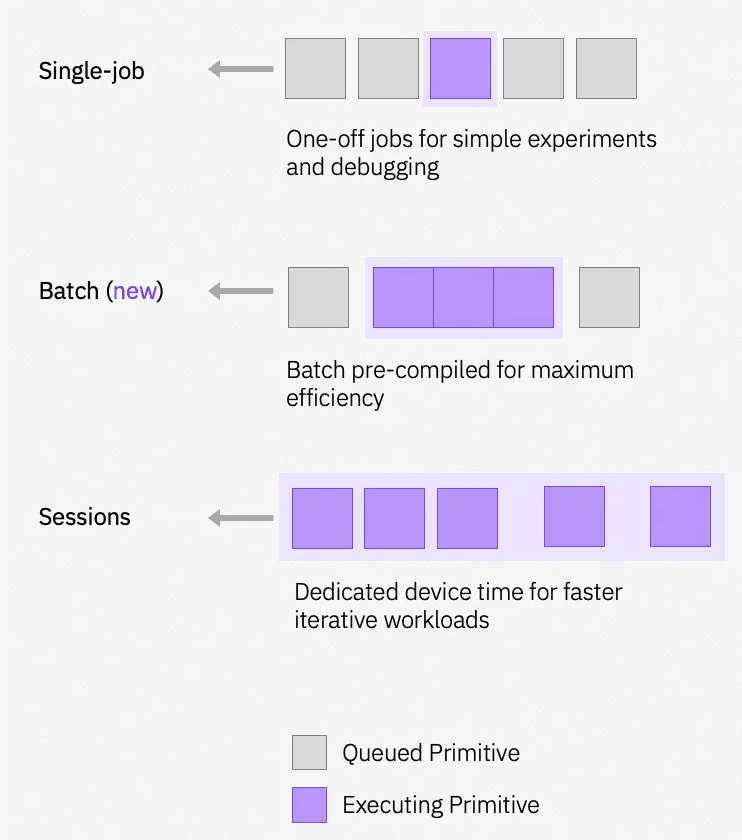

You can plug the sampler-based cost function into the SciPy minimizing routine to find the optimal parameters.

In [11]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [12]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.9252549900345741
       x: [ 3.271e+00  2.874e+00  2.641e+00  9.339e-01]
    nfev: 35
   maxcv: 0.0


The optimizer was able to reduce the cost and find better parameters for the circuit.

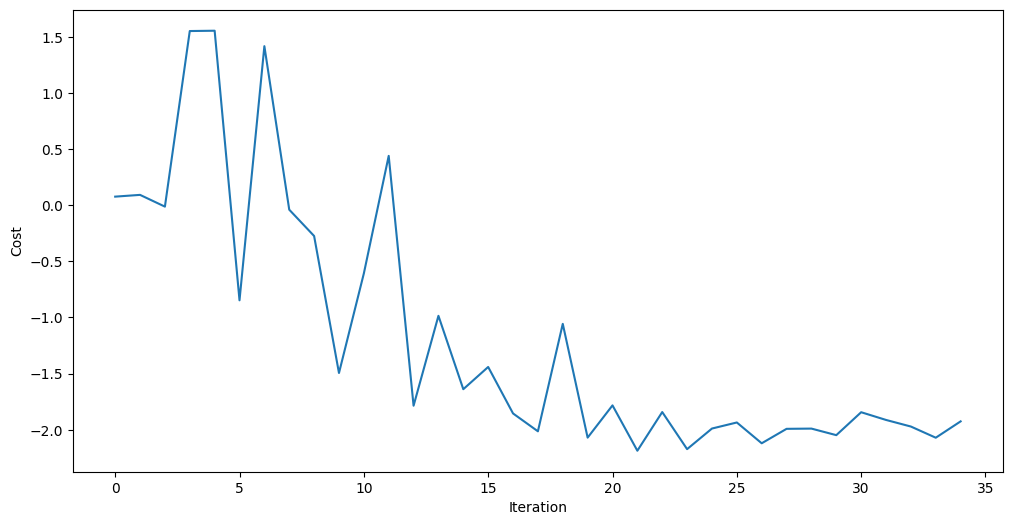

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once you have found the optimal parameters for the circuit, you can assign these parameters and sample the final distribution obtained with the optimized parameters. Here is where the *Sampler* primitive should be used since it is the probability distribution of bitstring measurements which correspond to the optimal cut of the graph.

<div class="alert alert-block alert-info">
This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state - for example, <code>010101110000...</code> - which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).
</div>
    


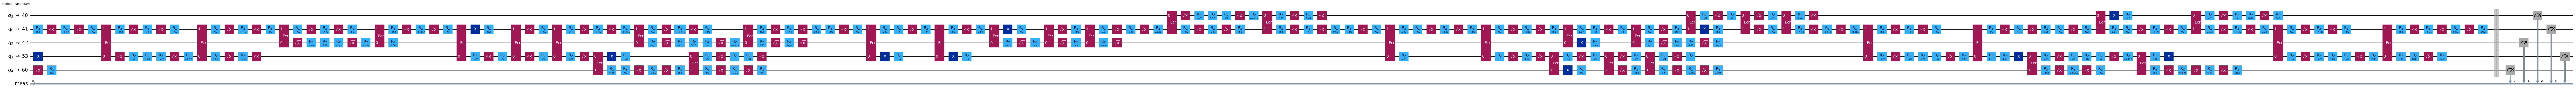

In [14]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [15]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{16: 0.0356, 18: 0.0753, 10: 0.0456, 21: 0.0456, 8: 0.0159, 19: 0.0288, 17: 0.0385, 1: 0.0234, 11: 0.0955, 31: 0.0038, 22: 0.0732, 28: 0.0137, 20: 0.08, 9: 0.0977, 6: 0.0138, 30: 0.0102, 2: 0.0127, 26: 0.0532, 13: 0.0354, 27: 0.0114, 0: 0.0087, 4: 0.0092, 5: 0.0432, 14: 0.0195, 25: 0.0196, 3: 0.0264, 24: 0.0128, 12: 0.0164, 15: 0.0094, 23: 0.009, 7: 0.0111, 29: 0.0054}


## Step 4. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for your original problem. In this case, you are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that four of the bitstrings are distictively more likely than the rest.

In [16]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 0]


/var/folders/dk/j4n5f_1d3xs7m8bq81g9gfk80000gn/T/ipykernel_76646/1639367914.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


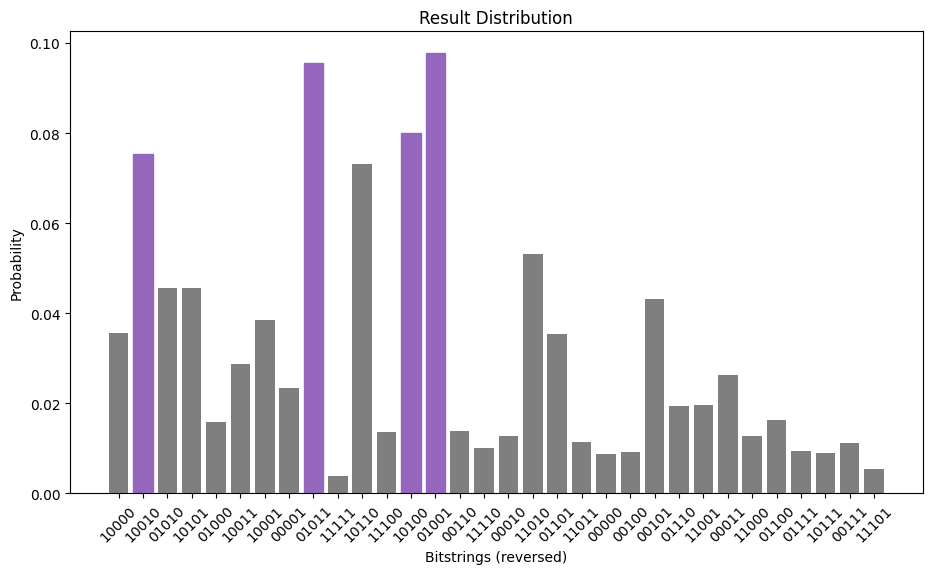

In [17]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

### Visualize best cut

From the optimal bit string, you can then visualize this cut on the original graph.

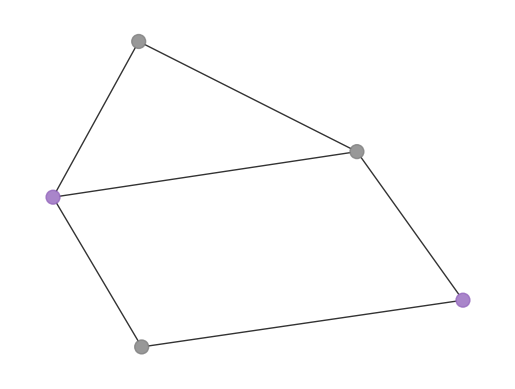

In [18]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

And calculate the value of the cut

In [27]:
from typing import Sequence


def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list())
    )


cut_value = evaluate_sample(most_likely_bitstring, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 5


---

# Part 2: scale it up!

You have access to many devices with over 100 qubits on IBM Quantum Platform. Select one on which to solve Max-Cut on a 100-node weighted graph. This is a "utility-scale" problem. The steps to build the workflow are followed the same as above, but with a much larger graph.


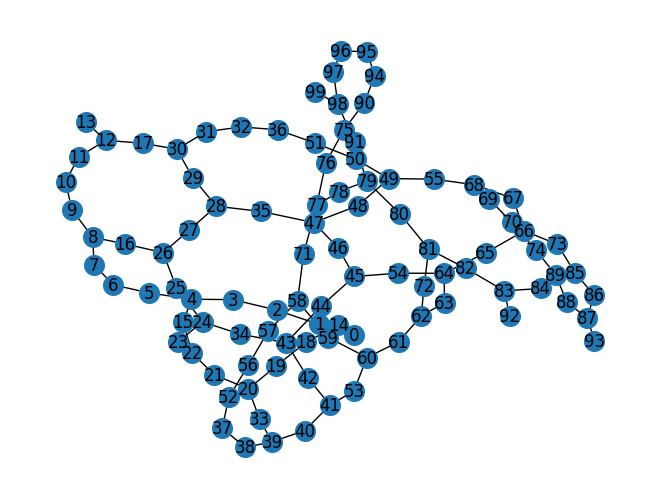

In [14]:
n = 100  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

## Step 1. Map classical inputs to a quantum problem

### Graph &rarr; Hamiltonian
First, convert the graph you want to solve directly into a Hamiltonian that is suited for QAOA.


In [15]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

### Hamiltonian &rarr; quantum circuit


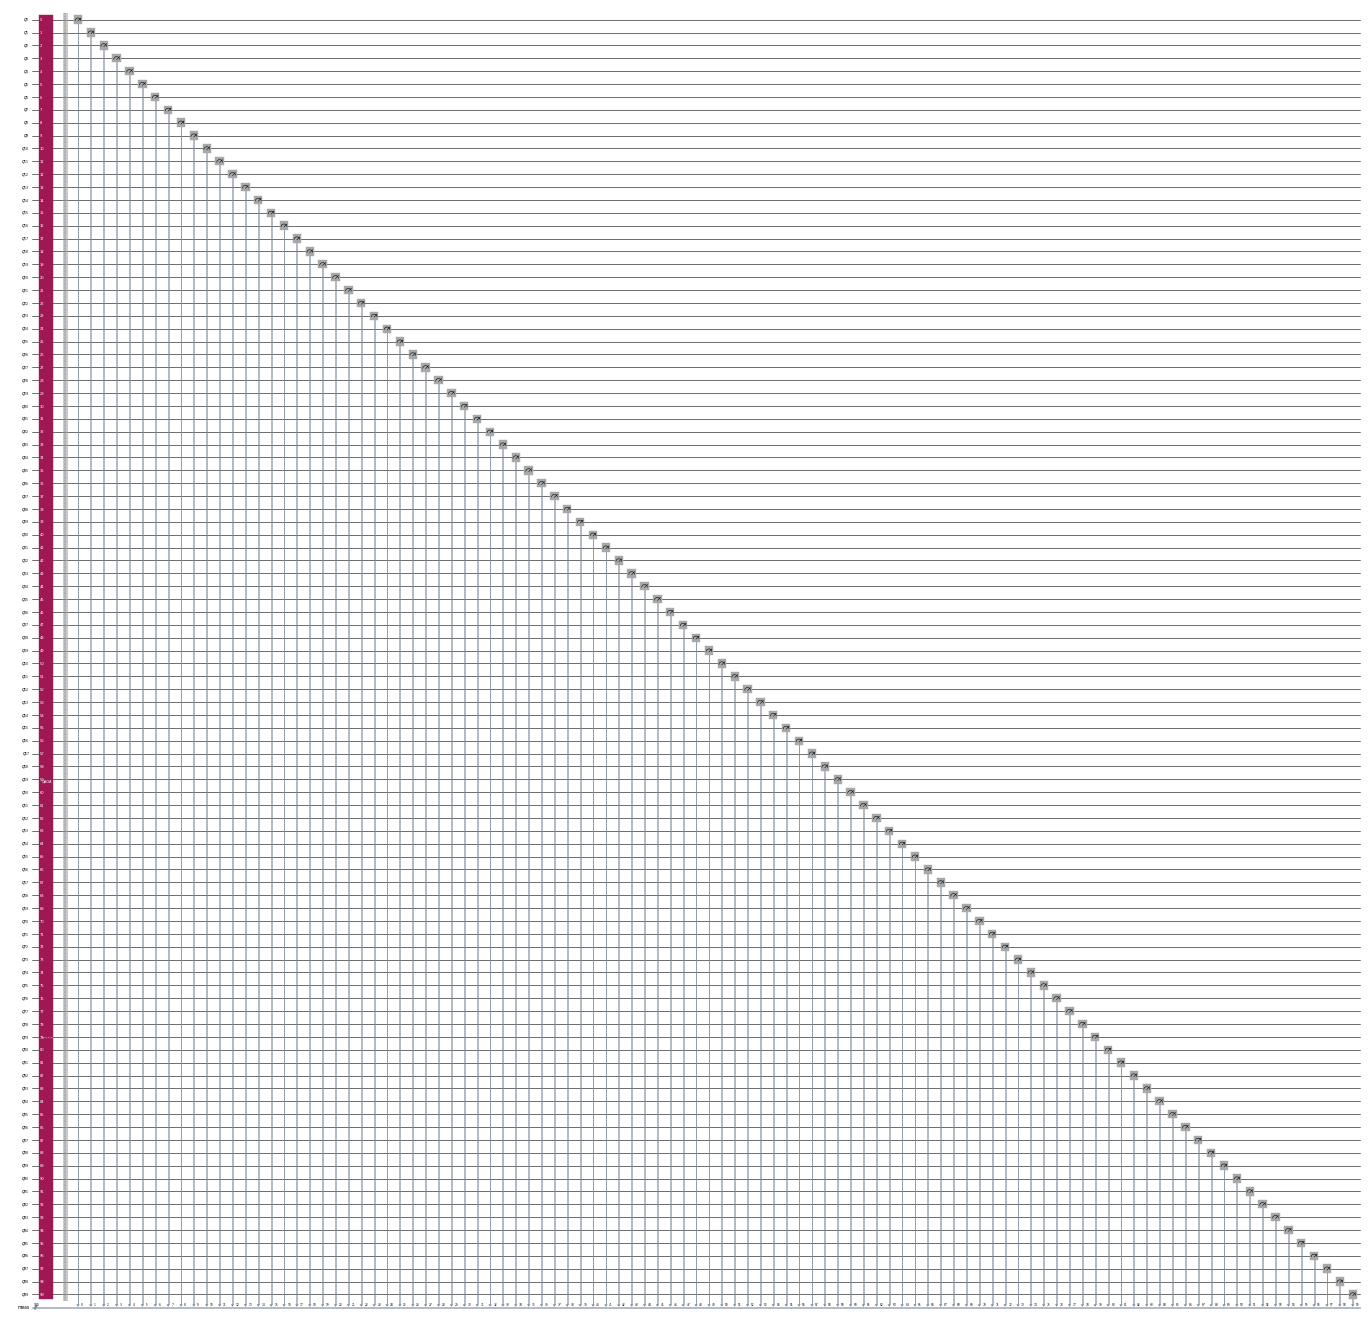

In [16]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw("mpl", fold=False, scale=0.2, idle_wires=False)

## Step 2. Optimize problem for quantum execution
To scale the circuit optimization step to utility-scale problems, you can take advantage of the high performance transpilation strategies introduced in Qiskit SDK v1.0. Other tools include the new transpiler service with [AI enhanced transpiler passes](https://docs.quantum.ibm.com/transpile/ai-transpiler-passes).



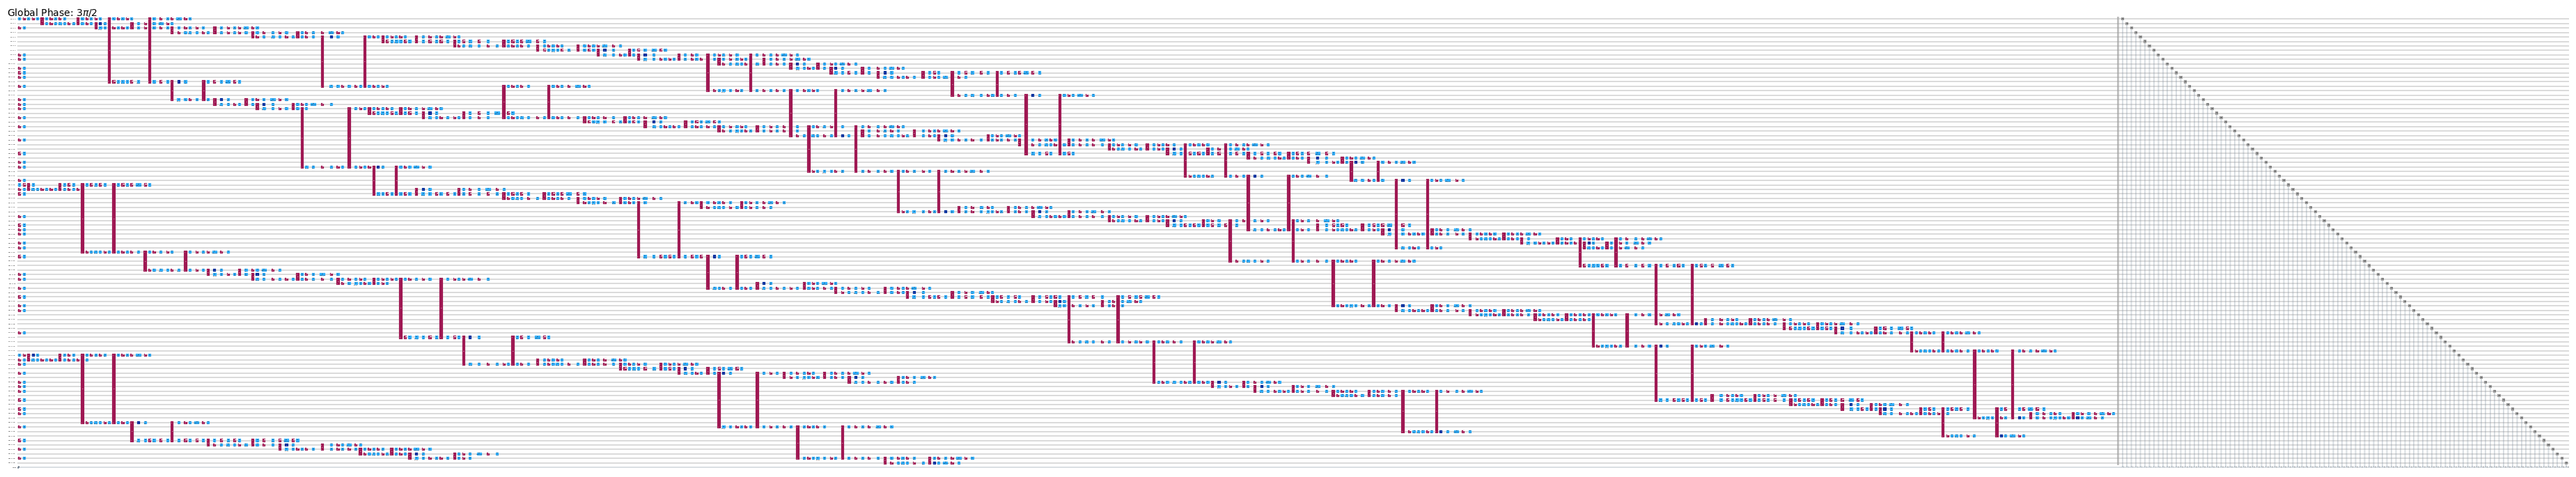

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw("mpl", fold=False, scale=0.1, idle_wires=False)

## Step 3. Execute using Qiskit primitives

To run QAOA, you must know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. Optimize these parameters by running an optimization loop on the device. The cell submits jobs until the cost function value has converged and the optimal parameters for $\gamma_k$ and $\beta_k$ are determined.

### Find candidate solution by running the optimization on the device

First, run the optimization loop for the circuit parameters on a device.

In [35]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta]

objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA",
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -43.594336255533044
       x: [ 2.751e+00  3.347e-01]
    nfev: 30
   maxcv: 0.0


Once the optimal parameters from running QAOA on the device have been found, assign the parameters to the circuit

In [36]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw("mpl", fold=False, idle_wires=False)

Finally, execute the circuit with the optimal parameters to sample from the corresponding distribution.

In [37]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"


pub = (optimized_circuit_100,)
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {key: val / shots for key, val in counts_int.items()}

## Step 4. Post-process, return result in classical format

Check that the cost minimized in the optimization loop has converged to a certain value. The code below uses the parameters corresponding to the minimum value of the cost.

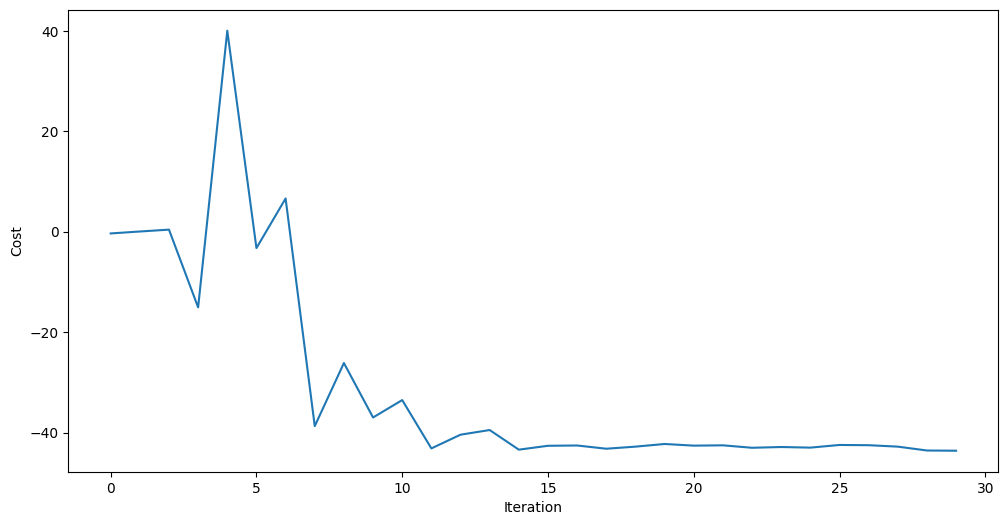

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Given that the likelihood of each solution is low, extract the solution that corresponds to the lowest cost.

In [39]:
_PARITY = np.array(
    [-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128
)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(
        state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8
    )
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])


def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol

    return min_sol


best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()

print("Result bitstring:", best_sol_bitstring_100)

Result bitstring: [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


Next, visualize the cut. Nodes of the same color belong to the same group.


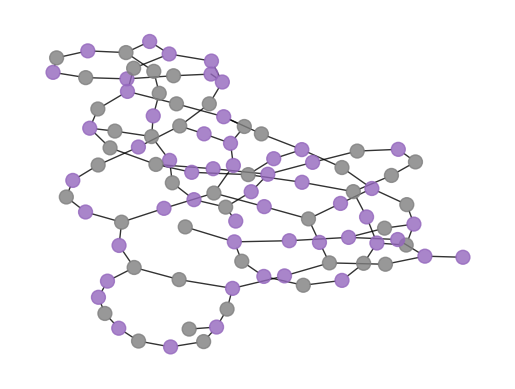

In [40]:
plot_result(graph_100, best_sol_bitstring_100)

And calculate the the value of the cut

In [41]:
cut_value_100 = evaluate_sample(best_sol_bitstring_100, graph_100)
print("The value of the cut is:", cut_value_100)

The value of the cut is: 84


Now you need to compute the objective value of each sample that you measured on the quantum computer. The sample with the lowest objective value is the solution returned by the quantum computer.

In [42]:
from collections import defaultdict
import matplotlib.pyplot as plt


# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)


def plot_cdf(dist, ax, title):
    _plot_cdf(
        dist,
        ax,
        "C1",
    )
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)


# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

In [43]:
result_dist = samples_to_objective_values(
    final_distribution_100_int, cost_hamiltonian_100
)

Finally, you can plot the cumulative distribution function to visualize how each sample contributes to the total probability distribution and the corresponding objective value. The horizontal spread shows the range of objective values of the samples in the final distribution. Ideally, you would see that the cumulative distribution function has "jumps" at the lower end of the objective function value axis. This would mean that few solutions with low cost have high probability of being sampled. A smooth, wide curve indicates that each sample is similarly likely, and they can have very different objective values, low or high.

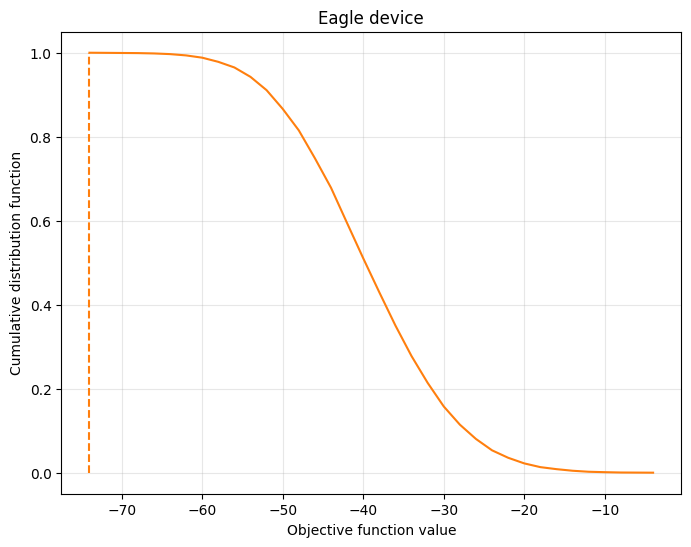

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Eagle device")

---

# Part 3: Advanced techniques

This section introduces advanced techniques to improve the performance of the QAOA algorithm with a large number of qubits. These techniques include:
- **SWAP strategy with SAT initial mapping**: This is a specifically designed transpiler for QAOA and uses a swap strategy and a SAT solver to find an initial mapping of the qubits in a circuit to the physical qubits on the device. The swap strategy is a pre-determined swap pattern that is applied to the circuit [1]. The SAT solver is used to find an initial mapping that minimizes the number of SWAP operations needed to map the qubits in the circuit to the physical qubits on the device [2].
- **CVaR cost function**: For a given set of shots with corresponding objective values of the considered optimization problem, the Conditional Value at Risk (CVaR) with confidence level $\alpha \in [0, 1]$ is defined as the average of the $\alpha$ best shots [3].
Thus, $\alpha = 1$ corresponds to the standard expected value, while $\alpha=0$ corresponds to the minimum of the given shots, and $\alpha \in (0, 1)$ is a tradeoff between focusing on better shots, but still applying some averaging to smoothen the optimization landscape.

References:

[1] Weidenfeller, J., Valor, L. C., Gacon, J., Tornow, C., Bello, L., Woerner, S., & Egger, D. J. (2022). Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware. Quantum, 6, 870.

[2] Matsuo, A., Yamashita, S., & Egger, D. J. (2023). A SAT approach to the initial mapping problem in SWAP gate insertion for commuting gates. IEICE Transactions on Fundamentals of Electronics, Communications and Computer Sciences, 106(11), 1424-1431.

[3] Barkoutsos, P. K., Nannicini, G., Robert, A., Tavernelli, I., & Woerner, S. (2020). Improving variational quantum optimization using CVaR. Quantum, 4, 256.

## Step 1. Map classical inputs to a quantum problem
### Graph -> Hamiltonian
First, convert the graph to solve directly into a Hamiltonian that is suited for QAOA.

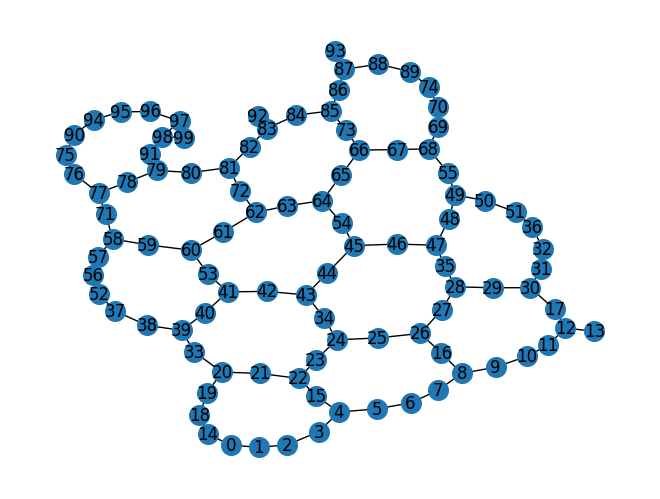

In [20]:
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

In [21]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

### Hamiltonian &rarr; quantum circuit


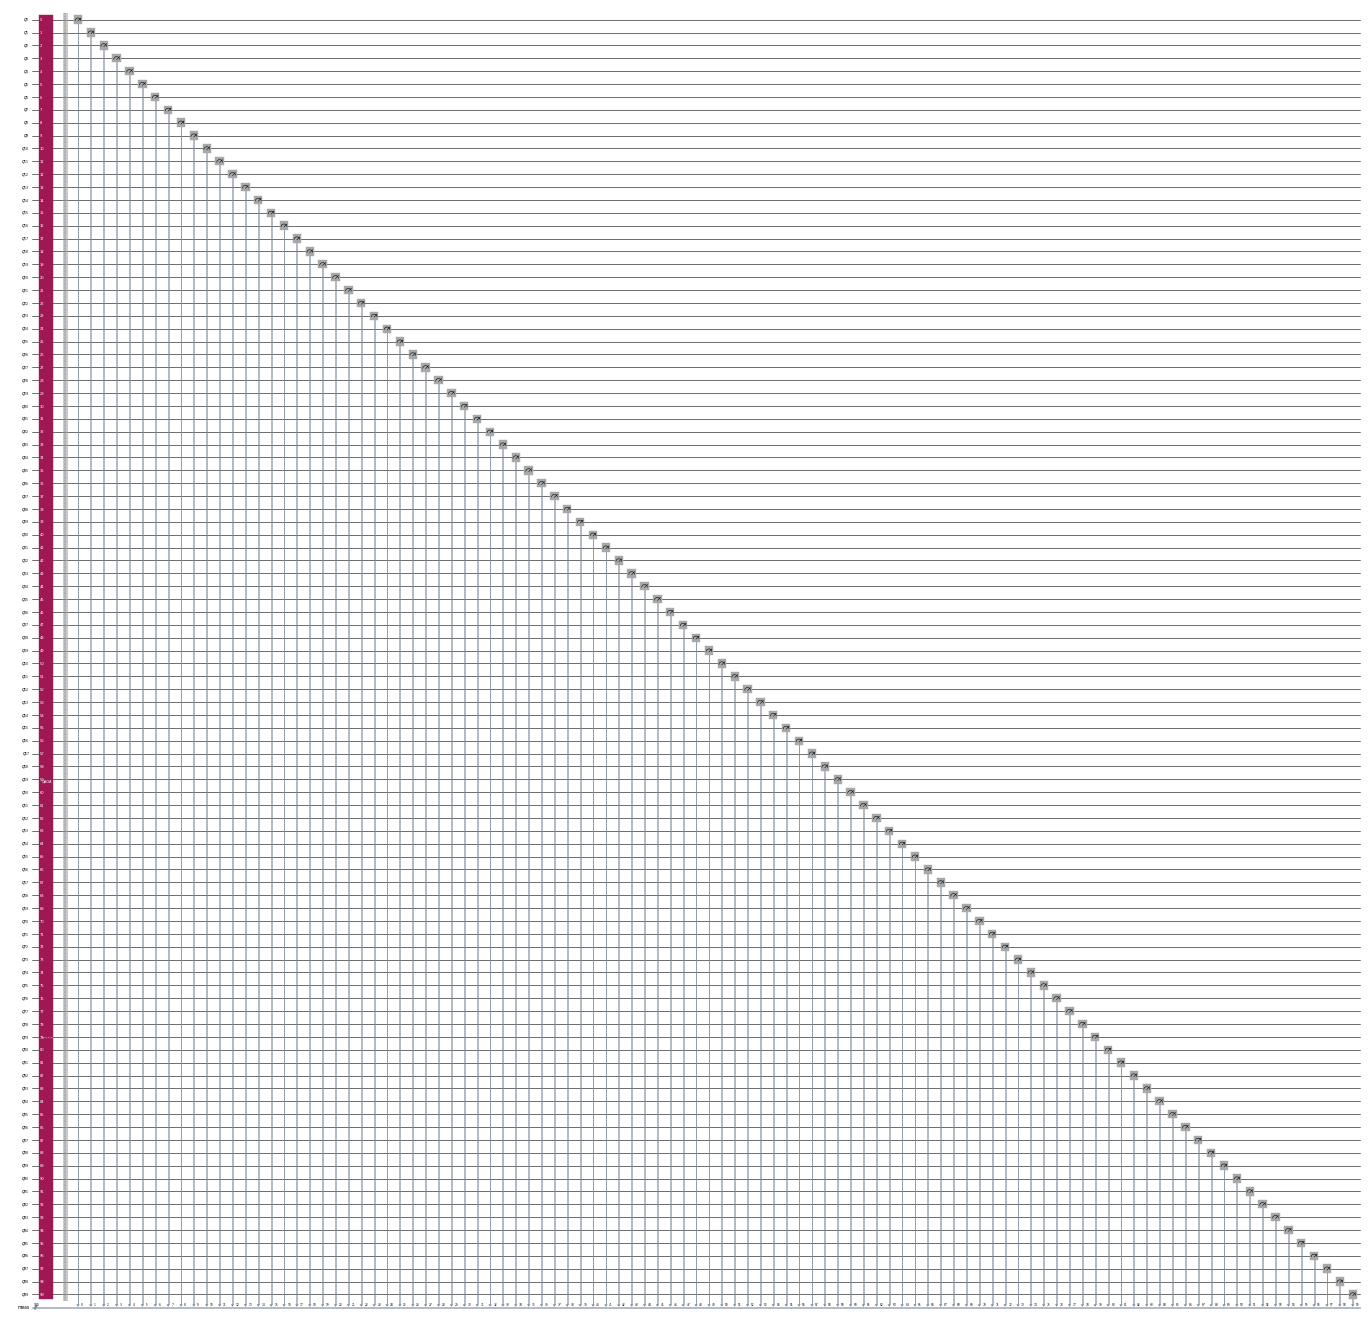

In [22]:
circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw("mpl", fold=False, scale=0.2, idle_wires=False)

## Step 2. Optimize problem for quantum execution
### SWAP strategy with the SAT initial mapping
We will demonstrate how to build and optimize QAOA circuits using the **SWAP strategy with SAT initial mapping**, a specifically designed transpiler pass for QAOA applied to quadratic problems.

In this example, we choose a SWAP insertion strategy for blocks of commuting two-qubit gates which applies layers of SWAP gates simultaneously executable on the coupling map. This strategy is presented in [1] and exposed as a standardized Qiskit transpiler pass, where we can choose different qubit configurations, in this case, a line.

In [23]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line(list(range(n)))

#### Remap the graph using a SAT mapper

Even when a circuit consists of commuting gates (this is the case for the QAOA circuit, but also for trotterized simulations of Ising Hamiltonians), finding a good initial mapping is a challenging task. The SAT-based approach presented in [2] enables the discovery of effective initial mappings for circuits with commuting gates, resulting in a significant reduction in the number of required SWAP layers. This approach has been demonstrated to scale to up to *500 qubits*, as illustrated in the paper.

The following code demonstrates how to use the `SATMapper` from Matsuo et al. to remap the graph. This process allows the problem to be mapped to a more optimal initial state for a specified SWAP strategy, resulting in a significant reduction in the number of SWAP layers required to execute the circuit.

In [117]:
"""A class to solve the SWAP gate insertion initial mapping problem
using the SAT approach from https://arxiv.org/abs/2212.05666.
"""

from __future__ import annotations

from dataclasses import dataclass
from itertools import combinations
from threading import Timer

import numpy as np

from pysat.formula import CNF, IDPool
from pysat.solvers import Solver


@dataclass
class SATResult:
    """A data class to hold the result of a SAT solver."""

    satisfiable: (
        bool  # Satisfiable is True if the SAT model could be solved in a given time.
    )
    solution: dict  # The solution to the SAT problem if it is satisfiable.
    mapping: (
        list  # The mapping of nodes in the pattern graph to nodes in the target graph.
    )
    elapsed_time: float  # The time it took to solve the SAT model.


class SATMapper:
    r"""A class to introduce a SAT-approach to solve
    the initial mapping problem in SWAP gate insertion for commuting gates.

    When this pass is run on a DAG it will look for the first instance of
    :class:`.Commuting2qBlock` and use the program graph :math:`P` of this block of gates to
    find a layout for a given swap strategy. This layout is found with a
    binary search over the layers :math:`l` of the swap strategy. At each considered layer
    a subgraph isomorphism problem formulated as a SAT is solved by a SAT solver. Each instance
    is whether it is possible to embed the program graph :math:`P` into the effective
    connectivity graph :math:`C_l` that is achieved by applying :math:`l` layers of the
    swap strategy to the coupling map :math:`C_0` of the backend. Since solving SAT problems
    can be hard, a ``time_out`` fixes the maximum time allotted to the SAT solver for each
    instance. If this time is exceeded the considered problem is deemed unsatisfiable and
    the binary search proceeds to the next number of swap layers :math:``l``.
    """

    def __init__(self, timeout: int = 60):
        """Initialize the SATMapping.

        Args:
            timeout: The allowed time in seconds for each iteration of the SAT solver. This
                variable defaults to 60 seconds.
        """
        self.timeout = timeout

    def find_initial_mappings(
        self,
        program_graph: rx.Graph,
        swap_strategy: SwapStrategy,
        min_layers: int | None = None,
        max_layers: int | None = None,
    ) -> dict[int, SATResult]:
        r"""Find an initial mapping for a given swap strategy. Perform a binary search
        over the number of swap layers, and for each number of swap layers solve a
        subgraph isomorphism problem formulated as a SAT problem.

        Args:
            program_graph (rx.Graph): The program graph with commuting gates, where
                                        each edge represents a two-qubit gate.
            swap_strategy (SwapStrategy): The swap strategy to use to find the initial mapping.
            min_layers (int): The minimum number of swap layers to consider. Defaults to
            the maximum degree of the program graph - 2.
            max_layers (int): The maximum number of swap layers to consider. Defaults to
            the number of qubits in the swap strategy - 2.

        Returns:
            dict[int, SATResult]: A dictionary containing the results of the SAT solver for
                                    each number of swap layers.
        """
        # pylint: disable=too-many-locals
        num_nodes_g1 = len(program_graph.nodes())
        num_nodes_g2 = swap_strategy.distance_matrix.shape[0]
        if num_nodes_g1 > num_nodes_g2:
            return SATResult(False, [], [], 0)
        if min_layers is None:
            # use the maximum degree of the program graph - 2 as the lower bound.
            min_layers = max((d for _, d in program_graph.degree)) - 2
        if max_layers is None:
            max_layers = num_nodes_g2 - 1

        variable_pool = IDPool(start_from=1)
        variables = np.array(
            [
                [variable_pool.id(f"v_{i}_{j}") for j in range(num_nodes_g2)]
                for i in range(num_nodes_g1)
            ],
            dtype=int,
        )
        vid2mapping = {v: idx for idx, v in np.ndenumerate(variables)}
        binary_search_results = {}

        def interrupt(solver):
            # This function is called to interrupt the solver when the timeout is reached.
            solver.interrupt()

        # Make a cnf for the one-to-one mapping constraint
        cnf1 = []
        for i in range(num_nodes_g1):
            clause = variables[i, :].tolist()
            cnf1.append(clause)
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])
        for j in range(num_nodes_g2):
            clause = variables[:, j].tolist()
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])

        # Perform a binary search over the number of swap layers to find the minimum
        # number of swap layers that satisfies the subgraph isomorphism problem.
        while min_layers < max_layers:
            num_layers = (min_layers + max_layers) // 2

            # Create the connectivity matrix. Note that if the swap strategy cannot reach
            # full connectivity then its distance matrix will have entries with -1. These
            # entries must be treated as False.
            d_matrix = swap_strategy.distance_matrix
            connectivity_matrix = ((-1 < d_matrix) & (d_matrix <= num_layers)).astype(
                int
            )
            # Make a cnf for the adjacency constraint
            cnf2 = []
            for e_0, e_1 in list(program_graph.edge_list()):
                clause_matrix = np.multiply(connectivity_matrix, variables[e_1, :])
                clause = np.concatenate(
                    (
                        [[-variables[e_0, i]] for i in range(num_nodes_g2)],
                        clause_matrix,
                    ),
                    axis=1,
                )
                # Remove 0s from each clause
                cnf2.extend([c[c != 0].tolist() for c in clause])

            cnf = CNF(from_clauses=cnf1 + cnf2)

            with Solver(bootstrap_with=cnf, use_timer=True) as solver:
                # Solve the SAT problem with a timeout.
                # Timer is used to interrupt the solver when the timeout is reached.
                timer = Timer(self.timeout, interrupt, [solver])
                timer.start()
                status = solver.solve_limited(expect_interrupt=True)
                timer.cancel()
                # Get the solution and the elapsed time.
                sol = solver.get_model()
                e_time = solver.time()

                if status:
                    # If the SAT problem is satisfiable, convert the solution to a mapping.
                    mapping = [vid2mapping[idx] for idx in sol if idx > 0]
                    binary_search_results[num_layers] = SATResult(
                        status, sol, mapping, e_time
                    )
                    max_layers = num_layers
                else:
                    # If the SAT problem is unsatisfiable, return the last satisfiable solution.
                    binary_search_results[num_layers] = SATResult(
                        status, sol, [], e_time
                    )
                    min_layers = num_layers + 1

        return binary_search_results

    def remap_graph_with_sat(
        self, graph: rx.Graph, swap_strategy
    ) -> tuple[int, dict, list] | tuple[None, None, None]:
        """Applies the SAT mapping.

        Args:
            graph (nx.Graph): The graph to remap.
            swap_strategy (SwapStrategy): The swap strategy to use to find the initial mapping.

        Returns:
            tuple: A tuple containing the remapped graph, the edge map, and the number of layers of
            the swap strategy that was used to find the initial mapping. If no solution is found
            then the tuple contains None for each element.
            Note the returned edge map `{k: v}` means that node `k` in the original
            graph gets mapped to node `v` in the Pauli strings.
        """
        num_nodes = len(graph.nodes())
        results = self.find_initial_mappings(graph, swap_strategy, 0, num_nodes - 1)
        solutions = [k for k, v in results.items() if v.satisfiable]

        if len(solutions):
            min_k = min(solutions)
            edge_map = dict(results[min_k].mapping)
            # Create the remapped graph
            remapped_graph = rx.PyGraph()
            remapped_graph.add_nodes_from(range(num_nodes))
            mapping = dict(results[min_k].mapping)
            for i, graph_edge in enumerate(list(graph.edge_list())):
                remapped_edge = tuple(mapping[node] for node in graph_edge)
                remapped_graph.add_edge(*remapped_edge, graph.edges()[i])
            return remapped_graph, edge_map, min_k
        else:
            return None, None, None

Map from old to new nodes:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99}
Min SWAP layers: 0


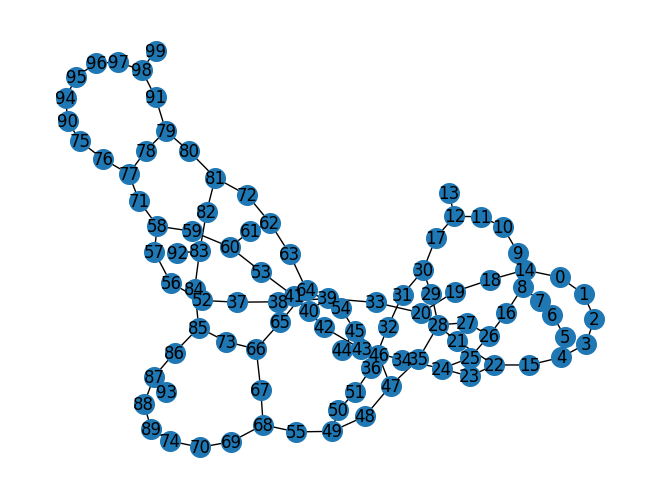

In [118]:
from qiskit.transpiler import CouplingMap

sm = SATMapper(timeout=10)
swap_strategy = SwapStrategy(CouplingMap(list(graph_100.edge_list())), ((())))
remapped_graph, edge_map, min_swap_layers = sm.remap_graph_with_sat(
    graph=graph_100, swap_strategy=swap_strategy
)
print("Map from old to new nodes: ", edge_map)
print("Min SWAP layers:", min_swap_layers)
draw_graph(remapped_graph, node_size=200, with_labels=True, width=1)

In [121]:
remapped_max_cut_paulis = build_max_cut_paulis(remapped_graph)
# define a qiskit SparsePauliOp from the list of paulis
remapped_cost_operator = SparsePauliOp.from_list(remapped_max_cut_paulis)
print(remapped_cost_operator)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

#### Build a QAOA circuit with the SWAP strategy and the SAT mapping
We only want to apply the SWAP strategies to the cost operator layer, so we will start by creating the isolated block that we will later transform and append to the final QAOA circuit.

For this means, we can use the `QAOAAnsatz` class from Qiskit. We will input an empty circuit to the `initial_state` and `mixer_operator` fields to make sure we are buiding an isolated cost operator layer.
We also define the edge_coloring map so that RZZGates are positioned next to SWAP gates. This strategic placement allows us to exploit CX cancellations, optimizing the circuit for better performance.
This process is executed within the `create_qaoa_swap_circuit` function. For a detailed explanation of how `create_qaoa_swap_circuit` works, please refer to the corresponding guide in the qopt-best-practice repository: [How to build a QAOA ansatz with SWAP strategies](https://github.com/qiskit-community/qopt-best-practices/blob/main/how_tos/how_to_build_qaoa_swap_circuit.ipynb) works.

In [134]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector


def make_meas_map(circuit: QuantumCircuit) -> dict:
    """Return a mapping from qubit index (the key) to classical bit (the value).

    This allows us to account for the swapping order introduced by the SwapStrategy.
    """
    creg = circuit.cregs[0]
    qreg = circuit.qregs[0]

    meas_map = {}
    for inst in circuit.data:
        if inst.operation.name == "measure":
            meas_map[qreg.index(inst.qubits[0])] = creg.index(inst.clbits[0])

    return meas_map


def apply_swap_strategy(
    circuit: QuantumCircuit,
    swap_strategy: SwapStrategy,
    edge_coloring: dict[tuple[int, int], int] | None = None,
) -> QuantumCircuit:
    """Transpile with a SWAP strategy.

    Returns:
        A quantum circuit transpiled with the given swap strategy.
    """

    pm_pre = PassManager(
        [
            FindCommutingPauliEvolutions(),
            Commuting2qGateRouter(
                swap_strategy,
                edge_coloring,
            ),
        ]
    )
    return pm_pre.run(circuit)


def apply_qaoa_layers(  # pylint: disable=too-many-arguments,too-many-locals
    cost_layer: QuantumCircuit,
    meas_map: dict,
    num_layers: int,
    gamma: list[float] | ParameterVector = None,
    beta: list[float] | ParameterVector = None,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Applies QAOA layers to construct circuit.

    First, the initial state is applied. If `initial_state` is None we begin in the
    initial superposition state. Next, we alternate between layers of the cot operator
    and the mixer. The cost operator is alternatively applied in order and in reverse
    instruction order. This allows us to apply the swap-strategy on odd `p` layers
    and undo the swap strategy on even `p` layers.
    """

    num_qubits = cost_layer.num_qubits
    new_circuit = QuantumCircuit(num_qubits, num_qubits)

    if initial_state is not None:
        new_circuit.append(initial_state, range(num_qubits))
    else:
        # all h state by default
        new_circuit.h(range(num_qubits))

    if gamma is None or beta is None:
        gamma = ParameterVector("γ", num_layers)
        if mixer is None or mixer.num_parameters == 0:
            beta = ParameterVector("β", num_layers)
        else:
            beta = ParameterVector("β", num_layers * mixer.num_parameters)

    if mixer is not None:
        mixer_layer = mixer
    else:
        mixer_layer = QuantumCircuit(num_qubits)
        mixer_layer.rx(-2 * beta[0], range(num_qubits))

    for layer in range(num_layers):
        bind_dict = {cost_layer.parameters[0]: gamma[layer]}
        cost_layer_ = cost_layer.assign_parameters(bind_dict)
        bind_dict = {
            mixer_layer.parameters[i]: beta[layer + i]
            for i in range(mixer_layer.num_parameters)
        }
        layer_mixer = mixer_layer.assign_parameters(bind_dict)

        if layer % 2 == 0:
            new_circuit.append(cost_layer_, range(num_qubits))
        else:
            new_circuit.append(cost_layer_.reverse_ops(), range(num_qubits))

        new_circuit.append(layer_mixer, range(num_qubits))

    for qidx, cidx in meas_map.items():
        new_circuit.measure(qidx, cidx)

    return new_circuit


def create_qaoa_swap_circuit(  # pylint: disable=too-many-arguments
    cost_operator: SparsePauliOp,
    swap_strategy: SwapStrategy,
    edge_coloring: dict = None,
    theta: list[float] = None,
    qaoa_layers: int = 1,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Create the circuit for QAOA.

    Notes: This circuit construction for QAOA works for quadratic terms in `Z` and will be
    extended to first-order terms in `Z`. Higher-orders are not supported.

    Args:
        cost_operator: the cost operator.
        swap_strategy: selected swap strategy
        edge_coloring: A coloring of edges that should correspond to the coupling
            map of the hardware. It defines the order in which we apply the Rzz
            gates. This allows us to choose an ordering such that `Rzz` gates will
            immediately precede SWAP gates to leverage CNOT cancellation.
        theta: The QAOA angles.
        qaoa_layers: The number of layers of the cost-operator and the mixer operator.
        initial_state: The initial state on which we apply layers of cost-operator
            and mixer.
        mixer: The QAOA mixer. It will be applied as is onto the QAOA circuit. Therefore,
            its output must have the same ordering of qubits as its input.
    """

    num_qubits = cost_operator.num_qubits

    if theta is not None:
        gamma = theta[: len(theta) // 2]
        beta = theta[len(theta) // 2 :]
        qaoa_layers = len(theta) // 2
    else:
        gamma = beta = None

    # First, create the ansatz of 1 layer of QAOA without mixer
    cost_layer = QAOAAnsatz(
        cost_operator,
        reps=1,
        initial_state=QuantumCircuit(num_qubits),
        mixer_operator=QuantumCircuit(num_qubits),
    ).decompose()

    # This will allow us to recover the permutation of the measurements that the swap introduce.
    cost_layer.measure_all()

    # Now, apply the swap strategy for commuting pauli evolution gates
    cost_layer = apply_swap_strategy(cost_layer, swap_strategy, edge_coloring)

    # Compute the measurement map (qubit to classical bit).
    # we will apply this for qaoa_layers % 2 == 1.
    if qaoa_layers % 2 == 1:
        meas_map = make_meas_map(cost_layer)
    else:
        meas_map = {idx: idx for idx in range(num_qubits)}

    cost_layer.remove_final_measurements()

    # Finally, introduce the mixer circuit and add measurements following measurement map
    circuit = apply_qaoa_layers(
        cost_layer, meas_map, qaoa_layers, gamma, beta, initial_state, mixer
    )

    return circuit

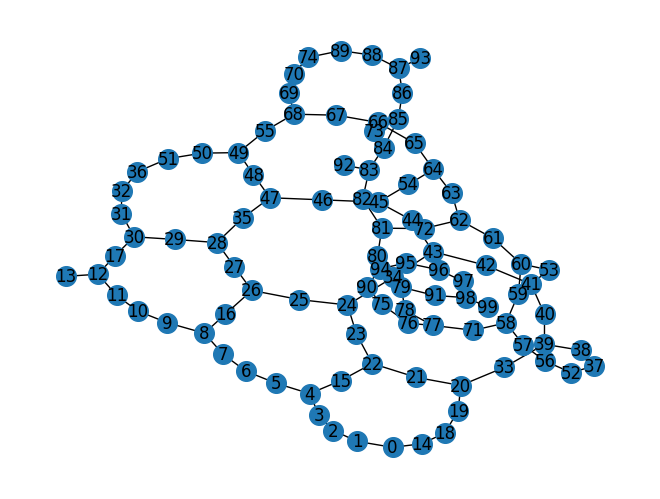

In [136]:
draw_graph(remapped_graph, node_size=200, with_labels=True, width=1)

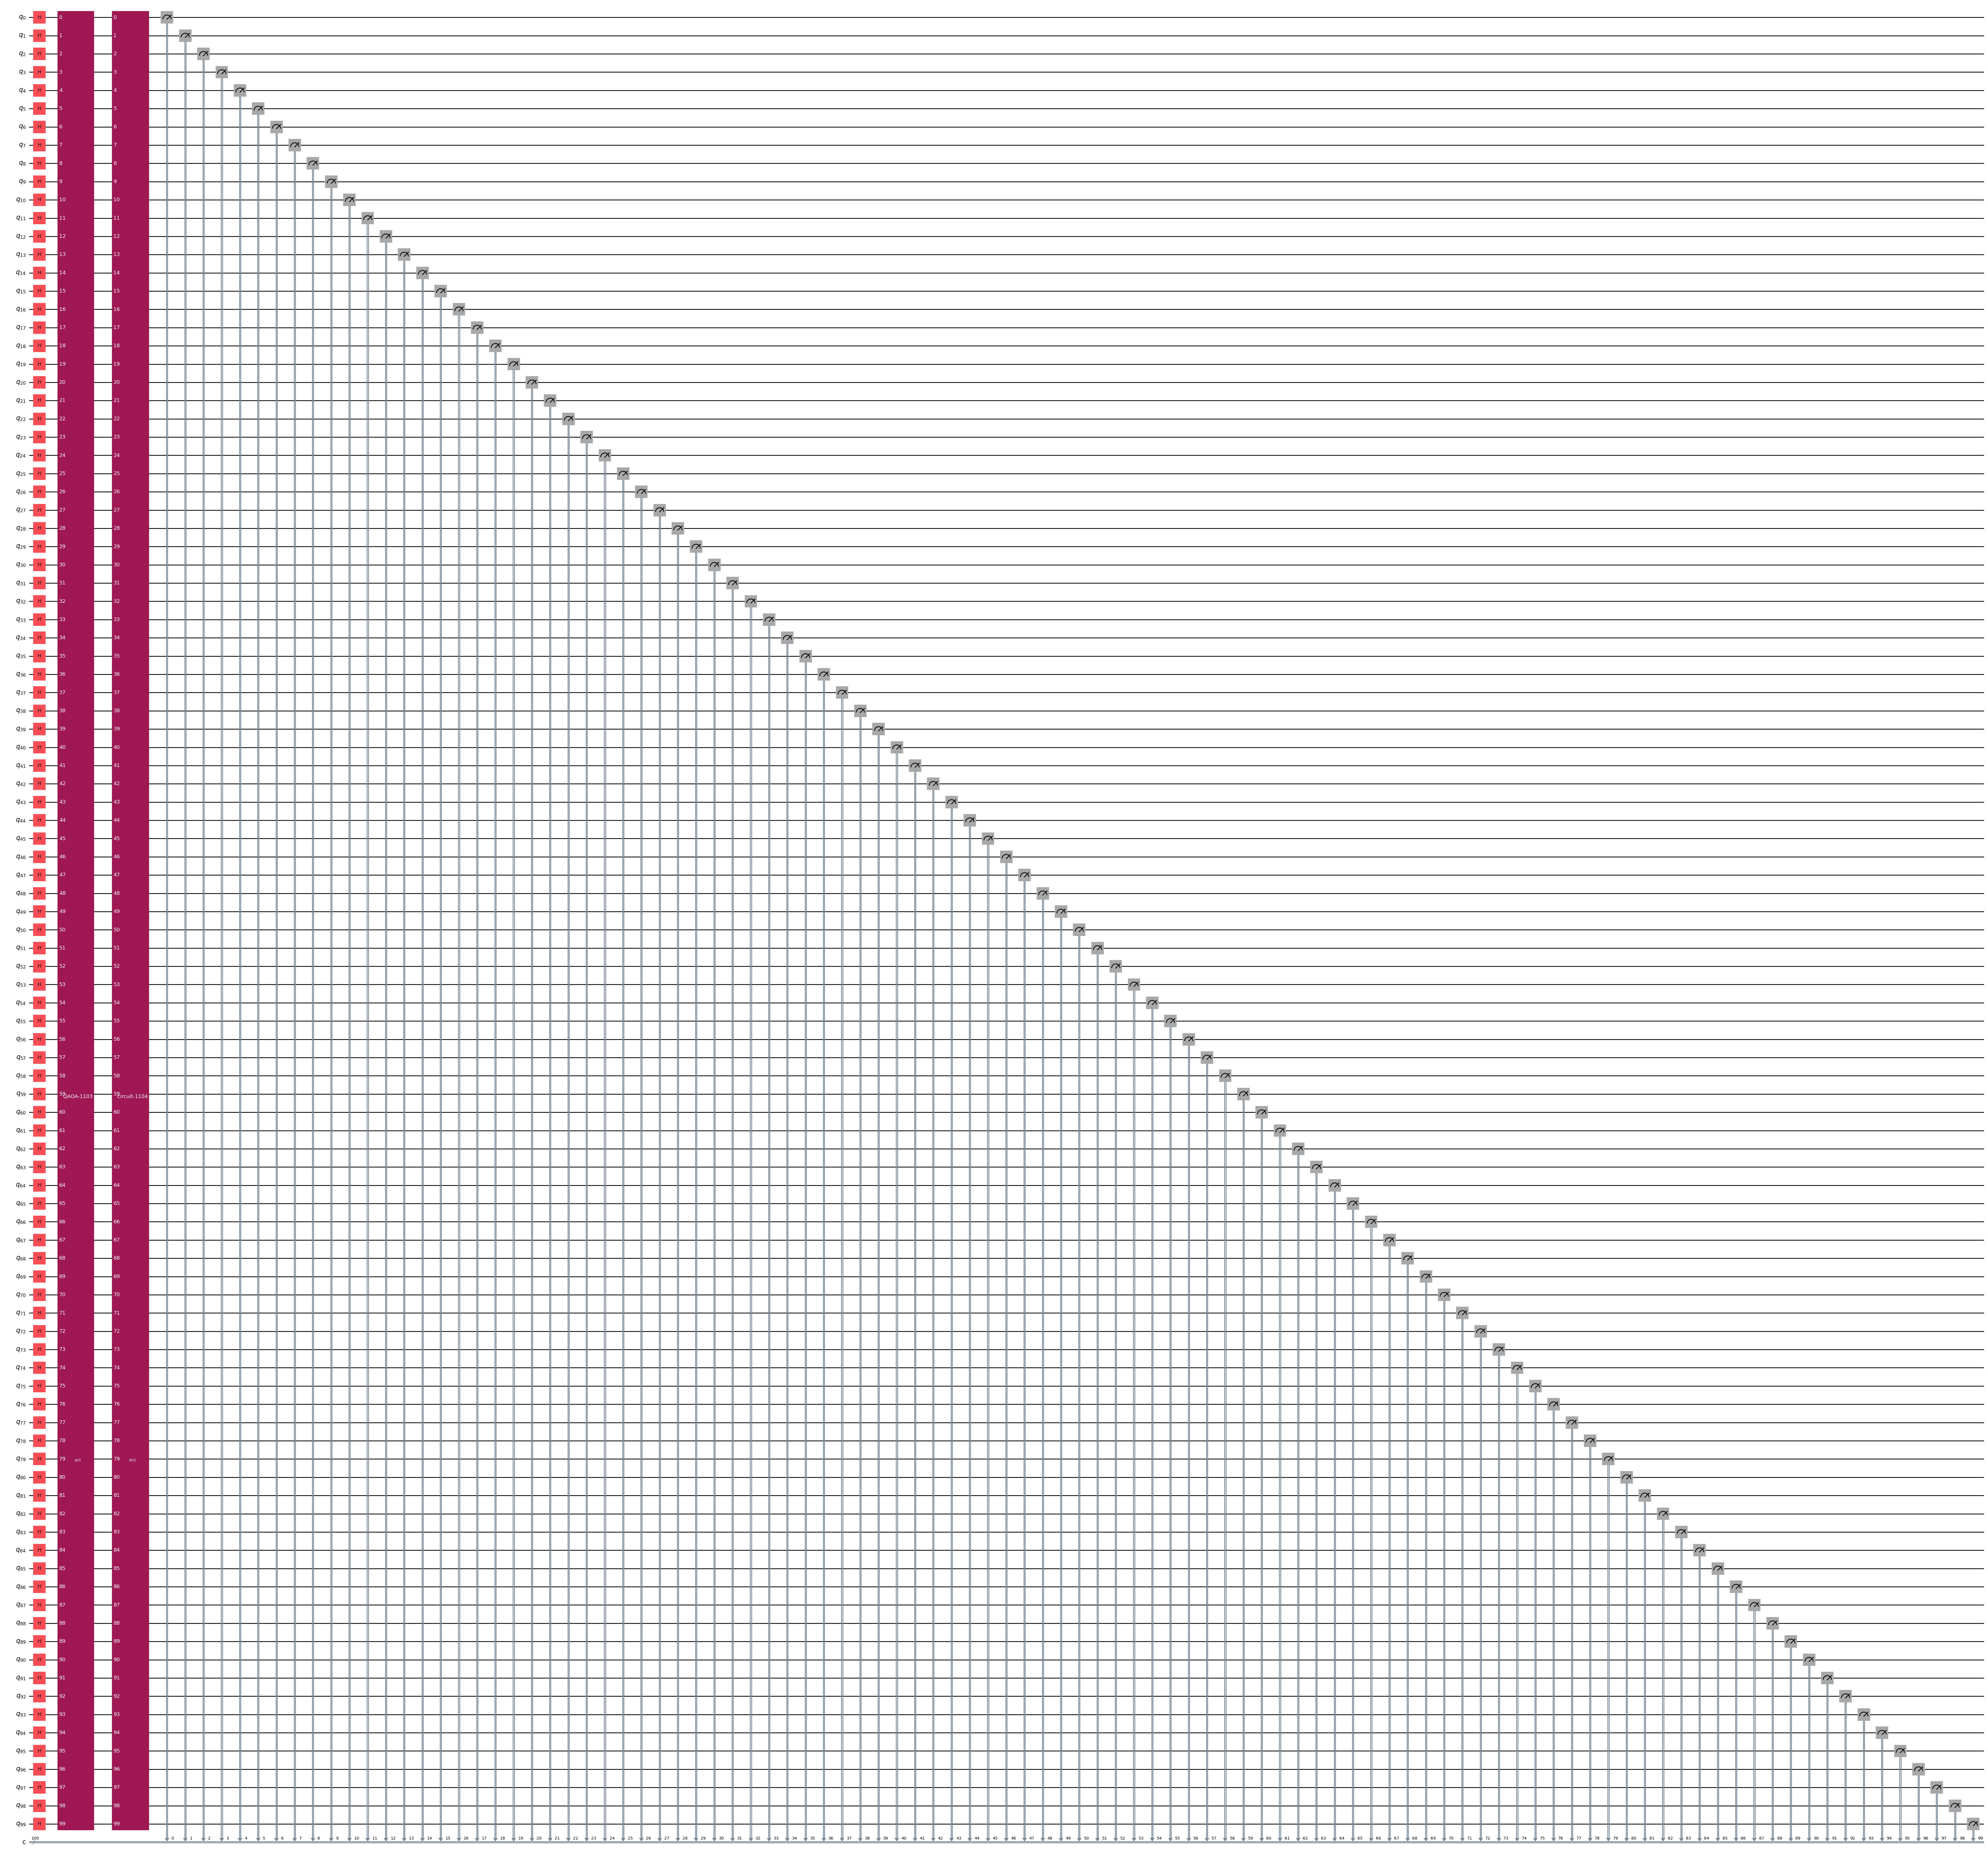

In [143]:
# We can define the edge_coloring map so that RZZGates are positioned next to SWAP gates to exploit CX cancellations
# edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(remapped_cost_operator.num_qubits)}
edge_coloring_idx = rx.graph_greedy_edge_color(remapped_graph)
edge_coloring = {
    edge: edge_coloring_idx[idx]
    for idx, edge in enumerate(list(remapped_graph.edge_list()))
}

qaoa_circ = create_qaoa_swap_circuit(
    remapped_cost_operator, swap_strategy, qaoa_layers=1
)
qaoa_circ.draw(output="mpl", fold=False)

## Step 3. Execute using Qiskit primitives
### Define a CVaR cost function
This example shows how to use the Conditional Value at Risk (CVaR) cost function introduced in [3] within the variational quantum optimization algorithms.
For a given set of shots with corresponding objective values of the considered optimization problem, the CVaR with confidence level $\alpha \in [0, 1]$ is defined as the average of the $\alpha$ best shots.
Thus, $\alpha = 1$ corresponds to the standard expected value, while $\alpha=0$ corresponds to the minimum of the given shots, and $\alpha \in (0, 1)$ is a tradeoff between focusing on better shots, but still applying some averaging to smoothen the optimization landscape.

In [144]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(min_num_qubits=127)
print(backend)

pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
)

transpiled_qaoa_circ = pass_manager.run(qaoa_circ)

<IBMBackend('ibm_kyiv')>


In [147]:
from collections.abc import Callable, Iterable


def qaoa_sampler_cost_fun(params, ansatz, hamiltonian, sampler, aggregation=None):
    """Standard sampler-based QAOA cost function to be plugged into optimizer routines.

    Args:
        params (np.ndarray): Parameters for the ansatz.
        ansatz (QuantumCircuit): Ansatz circuit.
        hamiltonian (SparsePauliOp): Hamiltonian to be minimized.
        sampler (QAOASampler): Sampler to be used.
        aggregation (Callable | float | None): Aggregation function to be applied to
            the sampled results. If None, the sum of the expectation values is returned.
            If float, the CVaR with the given alpha is used.
    """
    # Run the circuit
    job = sampler.run([(ansatz, params)])
    sampler_result = job.result()
    sampled_int_counts = sampler_result[0].data.meas.get_int_counts()
    shots = sum(sampled_int_counts.values())
    int_count_distribution = {
        key: val / shots for key, val in sampled_int_counts.items()
    }

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, float(evaluate_sparse_pauli(state, cost_hamiltonian_100)))
        for state, probability in int_count_distribution.items()
    }

    # If aggregation is None, return the sum of the expectation values.
    # If aggregation is a float, return the CVaR with the given alpha.
    # Otherwise, use the aggregation function.
    if aggregation is None:
        result = sum(probability * value for probability, value in evaluated.values())
    elif isinstance(aggregation, float):
        cvar_aggregation = _get_cvar_aggregation(aggregation)
        result = cvar_aggregation(evaluated.values())
    else:
        result = aggregation(evaluated.values())

    result = float(result)

    global iter_counts, result_dict
    iter_counts += 1
    temp_dict = {}
    temp_dict["params"] = params.tolist()
    temp_dict["cvar_fval"] = result
    temp_dict["normal_fval"] = sum(
        probability * value for probability, value in evaluated.values()
    )
    temp_dict["distribution"] = sampled_int_counts
    temp_dict["evaluated"] = evaluated
    result_dict[iter_counts] = temp_dict
    print(f"Iteration {iter_counts}: {result}")

    return result


def _get_cvar_aggregation(alpha: float | None) -> Callable:
    """Return the CVaR aggregation function with the given alpha.

    Args:
        alpha (float | None): Alpha value for the CVaR aggregation. If None, 1 is used
            by default.
    Raises:
        ValueError: If alpha is not in [0, 1].
    """
    if alpha is None:
        alpha = 1
    elif not 0 <= alpha <= 1:
        raise ValueError(f"alpha must be in [0, 1], but {alpha} was given.")

    def cvar_aggregation(objective_dict: Iterable[tuple[float, float]]) -> float:
        """Return the CVaR of the given measurements.
        Args:
            objective_dict (Iterable[tuple[float, float]]): An iterable of tuples containing
                the measured bit string and the objective value based on the bit string.

        """
        sorted_measurements = sorted(objective_dict, key=lambda x: x[1])
        # accumulate the probabilities until alpha is reached
        accumulated_percent = 0.0
        cvar = 0.0
        for probability, value in sorted_measurements:
            cvar += value * min(probability, alpha - accumulated_percent)
            accumulated_percent += probability
            if accumulated_percent >= alpha:
                break
        return cvar / alpha

    return cvar_aggregation

In [149]:
num_2q_ops = transpiled_qaoa_circ.count_ops()['ecr']

for el in backend.properties().general:
    if el.name[:2] == "lf" and el.name[3:] == str(n):
        lf = el.value  # layer fidelity
        print("layer fidelity", lf)
        elpg = 1 - lf ** (1 / (n - 1))  # elpg
        fid_cx = 1 - elpg
        gamma_cx = 1 / fid_cx**2
        gamma_circ = gamma_cx * num_2q_ops

cvar_aggregation = 1 / np.sqrt(gamma_circ)
print("")
print("The corresponding CVaR aggregation value is: ", cvar_aggregation)
print("To mitigate the twirled noise, increase shots by ", np.sqrt(gamma_circ))

layer fidelity 0.1795615211784291

The corresponding CVaR aggregation value is:  0.06566633706864092
To mitigate the twirled noise, increase shots by  15.228502831743175


In [ ]:
from scipy.optimize import minimize
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

iter_counts = 0
result_dict = {}
init_params = [np.pi, np.pi / 2]


with Session(backend=backend) as session:
    sampler = Sampler(session=session)

    shots = 1000
    sampler.options.default_shots = int(shots * np.sqrt(gamma_circ))

    # Set error suppression/mitigation options
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = "XY4"
    sampler.options.twirling.enable_gates = True
    sampler.options.twirling.num_randomizations = "auto"
    sampler.options.twirling.enable_measure = True

    # Run optimization loop
    result = minimize(
        qaoa_sampler_cost_fun,
        init_params,
        args=(
            candidate_circuit_100,
            cost_hamiltonian_100,
            sampler,
            cvar_aggregation,
        ),
        method="COBYLA",
        tol=1e-2,
    )
print(result)

## Step 4. Post-process, return result in classical format

Calculate the the value of the cut.

In [ ]:
best_sol_100_cvar = best_solution(result_dict[-1]["distribution"], remapped_cost_operator)
best_sol_bitstring_100_cvar = to_bitstring(int(best_sol_100_cvar), len(graph_100))
best_sol_bitstring_100_cvar.reverse()

print("Result bitstring:", best_sol_bitstring_100_cvar)

In [ ]:
cut_value = evaluate_sample(best_sol_bitstring_100_cvar, graph)
print("The value of the cut is:", cut_value)

Next, visualize the cut. Nodes of the same color belong to the same group.


In [ ]:
#plot the results
import matplotlib.pyplot as plt
plt.plot([result_dict[i]['cvar_fval'] for i in result_dict])
plt.xlabel('Iterations')
plt.ylabel('Cost function value')
plt.title('QAOA optimization')
plt.show()

## Conclusion

This tutorial demonstrated how to solve an optimization problem with a quantum computer using the Qiskit patterns framework. The demonstration included a utility-scale example, with circuit sizes that cannot be exactly simulated classically. Currently, quantum computers do not outperform classical computers for combinatorial optimization because of noise. However, the hardware is steadily improving, and new algorithms for quantum computers are continually being developed. Indeed, much of the research working on quantum heuristics for combinatorial optimization is tested with classical simulations that only allow for a small number of qubits, typically around 20 qubits. Now, with larger qubit counts and devices with less noise, researchers will be able to start benchmarking these quantum heuristics at large problem sizes on quantum hardware.